In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
from scipy import stats as sts
import shap
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

In [2]:
tag_users = pd.read_csv("data/tag_users.csv")
tag_questions = pd.read_csv("data/tag_questions.csv")
tags = pd.read_csv("data/tags.csv")
professionals = pd.read_csv("data/professionals.csv")
answers = pd.read_csv("data/answers.csv")
emails1 = pd.read_csv("data/emails1.csv")
emails2 = pd.read_csv("data/emails2.csv")
emails = pd.concat([emails1,emails2])
questions = pd.read_csv("data/questions.csv")
matches1 = pd.read_csv("data/matches1.csv")
matches2 = pd.read_csv("data/matches2.csv")
matches3 = pd.read_csv("data/matches3.csv")
matches = pd.concat([matches1,matches2,matches3])
answers_scores = pd.read_csv("data/answer_scores.csv")
group_members = pd.read_csv("data/group_memberships.csv")
schools_members = pd.read_csv("data/school_memberships.csv")

In [3]:
def get_user_tags(user_id):
    user_tags = tag_users[tag_users["tag_users_user_id"] == user_id]["tag_users_tag_id"]
    tags_names =tags.loc[tags["tags_tag_id"].isin(user_tags)]
    return(tags)

In [4]:
def get_user_answers(user_id):
    all_answers = answers.loc[answers["answers_author_id"]==user_id]
    return all_answers

In [5]:
def match_email_question(email_date):
    f = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC+0000")
    b  =f(email_date)
    t = questions["questions_date_added"].apply(f)
    return questions.iloc[(b-t).abs().argsort()[:1]]

In [6]:
# get only emails that were sent immediately after getting the question (ignore the weekly newsletter emails)
immediate_emails = emails[emails["emails_frequency_level"]=="email_notification_immediate"]

# get the matches of the immediate emails only
immediate_matches = matches[matches["matches_email_id"].isin(immediate_emails["emails_id"])]
# get the emails that have their matches only (the data is missing the matches of some emails so we ignore those)
immediate_emails = immediate_emails[immediate_emails["emails_id"].isin(matches["matches_email_id"])]
# some renaming for convience
immediate_emails = immediate_emails.rename(columns={'emails_id':"id"})
immediate_matches = immediate_matches.rename(columns={'matches_email_id':"id"})
# let's put the emails and their matches question id:
emails_questions = pd.merge(immediate_emails, immediate_matches, how="left", on="id")
#some renaming:
emails_questions = emails_questions.rename(columns = {"matches_question_id": "question_id", "emails_recipient_id": "professional_id"})
answers = answers.rename(columns = {"answers_question_id": "question_id", "answers_author_id": "professional_id"})

# now, let's make a big data that has emails, questions sent, and answers. Note that some professionals provided more than
# one answer to the same question. So this means the email Id will be repeated because it has two answers
full_data = pd.merge(emails_questions, answers,how='left',  on=["professional_id","question_id" ])
full_data = full_data.rename(columns = {"id": "email_id"})

# get the target variable by looking ad the answer and putting 1 if it exists and 0 if not:
target = full_data['answers_id'].fillna(0)
target = pd.to_numeric(target, errors='coerce').fillna(1).astype(int) #here just turn str to NA then replace with 1
full_data["q_answered?"] = target

# turn the email sent date into a datetime value instead of a string
date_vectorizer = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC+0000")
full_data["emails_date_sent"] = full_data["emails_date_sent"].apply(date_vectorizer)
# turn the asnwer added data to datetime value instead of a string (while ignoring the NAs)
indices = full_data["answers_date_added"][full_data["answers_date_added"].notnull()].index.values
full_data.loc[indices, "answers_date_added"] = full_data["answers_date_added"][full_data["answers_date_added"].notnull()].apply(date_vectorizer)
#adding the time taken for each professional to answer a question
full_data["time_taken"] =  pd.to_datetime(full_data["answers_date_added"]) - pd.to_datetime(full_data["emails_date_sent"])

# some people were too active and answered the question even before the email was sent to them. So that would lead
# to a negative time_taken. So we fix that by putting a zero for the time they took (they answered it immediately)
indices2 = full_data["time_taken"][full_data["time_taken"] < datetime.timedelta( days=0)].index.values
full_data.loc[indices2, "time_taken"]=datetime.timedelta(days=0, seconds=0,minutes=0, hours=0 )
# get all the tags of each question
tag_questions_names = pd.merge(tag_questions.rename(columns = {"tag_questions_tag_id":"tag_id"}), tags.rename(columns = {"tags_tag_id":"tag_id"}),how='left',  on=["tag_id" ])
tag_questions_names = tag_questions_names.rename(columns ={"tag_questions_question_id":"question_id", "tags_tag_name":"tag_name"})
questions_tags = tag_questions_names.groupby("question_id")["tag_name"].apply(list).reset_index(name="q_tags")
full_data = pd.merge(full_data,questions_tags,how='left',  on=["question_id" ])

In [7]:
# creating a data for all the professionals
professionals_dataset = pd.DataFrame(columns = ["professional_id"])
professionals_dataset["professional_id"] = professionals["professionals_id"]
# getting the response rate by counting the number of questions answered after the email was sent
response = full_data.groupby("professional_id").mean().drop(columns = ["email_id"]).reset_index()
professionals_dataset = pd.merge(professionals_dataset, response,how='left',  on=["professional_id" ])
professionals_dataset = professionals_dataset.rename(columns = {"q_answered?": "response_rate"})

# getting the average time they took to answer the question if they did
grouped = full_data.groupby('professional_id')["time_taken"]
time_mean = grouped.apply(lambda x: np.mean(x))
professionals_dataset = pd.merge(professionals_dataset, time_mean,how='left',  on=["professional_id" ])
professionals_dataset=  professionals_dataset.rename(columns ={"time_taken": "avg_time_taken"})
# count the total number of questions that each professional answered (including those answered after email)
answers_count = answers["professional_id"].value_counts().reset_index().rename(columns = {"professional_id":"number_q_answered","index":"professional_id",  })
professionals_dataset = pd.merge(professionals_dataset, answers_count,how='left',  on=["professional_id" ])
professionals_dataset["number_q_answered"]= professionals_dataset["number_q_answered"].fillna(0)

# get all the tags that each professional is following
all_tags = pd.merge(tag_users.rename(columns = {"tag_users_tag_id": "tag_id"}),tags.rename(columns = {"tags_tag_id": "tag_id"}),how='left',  on=["tag_id" ])
foll_tags = all_tags.groupby('tag_users_user_id')['tags_tag_name'].apply(lambda x: list(set(x))).reset_index(name='following_tags').rename(columns = {"tag_users_user_id": "professional_id"})
professionals_dataset = pd.merge(professionals_dataset, foll_tags,how='left',  on=["professional_id" ])
# get all the tags of the questions that he answered before
a = full_data[["professional_id","q_tags"]][full_data["q_tags"].notnull()].groupby("professional_id")["q_tags"].agg(sum).apply(lambda x: list(set(x)))
professionals_dataset = pd.merge(professionals_dataset, a,how='left',  on=["professional_id" ])
professionals_dataset = professionals_dataset.rename(columns = {"q_tags": "prev_q_tags"})
# get the average score for each professional

prof_score = pd.merge(answers[["professional_id","answers_id" ]], answers_scores.rename(columns = {"id":"answers_id"}),how='left',  on=["answers_id" ]).drop(columns = ["answers_id"])
score_mean = prof_score.groupby("professional_id").mean().reset_index()
professionals_dataset = pd.merge(professionals_dataset,score_mean,how='left',  on=["professional_id" ]).rename(columns = {"score":"avg_ansrs_score"})
professionals_dataset["avg_ansrs_score"] = professionals_dataset["avg_ansrs_score"].fillna(0)
# get the number of groups that each professional is following
prof_grp = group_members["group_memberships_user_id"].value_counts().reset_index().rename(columns = {"index":"professional_id", "group_memberships_user_id":"num_groups"})
professionals_dataset = pd.merge(professionals_dataset,prof_grp,how='left',  on=["professional_id" ])
# get the number of schools that each professional is following
prof_schl = schools_members["school_memberships_user_id"].value_counts().reset_index().rename(columns = {"index":"professional_id", "school_memberships_user_id":"num_schools"})
professionals_dataset = pd.merge(professionals_dataset,prof_schl,how='left',  on=["professional_id" ])
#get the answers to email ratio (#answers/#emails sent) for each professional

prof_emls = immediate_emails["emails_recipient_id"].value_counts().reset_index().rename(columns = {"index":"professional_id", "emails_recipient_id":"num_emails"})
professionals_dataset = pd.merge(professionals_dataset,prof_emls,how='left',  on=["professional_id" ])
professionals_dataset["answrs_emails_ratio"] = professionals_dataset["number_q_answered"] / professionals_dataset["num_emails"]


In [8]:
full_data.head(1)

,Unnamed: 0_x,email_id,professional_id,emails_date_sent,emails_frequency_level,Unnamed: 0_y,question_id,answers_id,answers_date_added,answers_body,q_answered?,time_taken,q_tags
0,292,508143,0c673e046d824ec0ad0ebe012a0673e4,2016-05-20 20:07:48,email_notification_immediate,3291613,b551946952ae4328864414a9164a95d8,NaN,NaN,NaN,0,NaT,"[guidance-counselor, school-counselor, school,..."


In [9]:
professionals_dataset.head(1)

,professional_id,Unnamed: 0_x,Unnamed: 0_y,response_rate,avg_time_taken,number_q_answered,following_tags,prev_q_tags,avg_ansrs_score,num_groups,num_schools,num_emails,answrs_emails_ratio
0,9ced4ce7519049c0944147afb75a8ce3,NaN,NaN,NaN,NaT,1.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN


In [10]:
professionals_dataset[professionals_dataset.avg_time_taken.notnull()]

,professional_id,Unnamed: 0_x,Unnamed: 0_y,response_rate,avg_time_taken,number_q_answered,following_tags,prev_q_tags,avg_ansrs_score,num_groups,num_schools,num_emails,answrs_emails_ratio
10,7d425e8d7cfb4fe7b0702fff4d6d84e7,8.798182e+02,2.506310e+06,0.080808,0 days 09:07:59,43.0,"[political-science, latin-america, teaching, p...","[fashion, educator, experienced, professors, c...",1.697674,NaN,NaN,198.0,0.217172
15,68ecc66323b8418092fdd724aaf5be94,1.864500e+03,2.500534e+06,0.071429,0 days 05:15:37,9.0,"[event-planning, hospitality]","[volunteer, public-relations, communications, ...",2.222222,NaN,NaN,14.0,0.642857
27,2a8328f6ceb548699a64293f986f3d19,3.964516e+03,2.525227e+06,0.048387,0 days 18:13:05.333333,15.0,"[international, law]","[educator, law-enforcement, professors, sherif...",2.933333,NaN,NaN,124.0,0.120968
50,70f812ce6f57465fa79531f8c56ecdf8,7.383153e+03,2.396877e+06,0.016949,0 days 00:28:37,2.0,[technology],"[computer-gaming, anesthesiologist, travel, bu...",2.000000,NaN,NaN,59.0,0.033898
52,1e4cc96c24344c8b806c26c3e6746167,7.543765e+03,2.462448e+06,0.117647,0 days 00:14:58,14.0,"[food, restaurants, restaurant]","[culinary, personal-chef, cooking, food, cook,...",2.142857,NaN,NaN,17.0,0.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19094,9f045ce7ac9e45bba07858a8e8be39c6,1.719547e+06,1.642991e+06,0.043478,0 days 01:39:00,1.0,"[mortgage-career, mortgage-lending2, loans, mo...","[school, studentloans, psychiatry, student, pr...",0.000000,NaN,NaN,23.0,0.043478
21397,85043fa9a4db46199558715bb2b0b490,1.781618e+06,1.447522e+06,0.137931,0 days 13:22:11.250000,47.0,"[history, fashion, christian, life-coach, teen...","[studying, admissions, med-school, exams, occu...",0.063830,NaN,3.0,116.0,0.405172
22677,e2b4c84bf1ca4aea9b108869692d8017,1.798968e+06,1.334372e+06,0.677966,1 days 09:40:49.400000,133.0,"[macos, technical-writing, unix, innovation, s...","[technical-writing, therapist, student, writer...",0.195489,NaN,NaN,109.0,1.220183
24454,a7bf251a290b418e923e8f04a67b7ebb,1.827599e+06,5.043470e+05,1.000000,0 days 02:52:16,13.0,"[artificial-intelligence, engineering, game-de...","[controlsystems, computer, engineer, mechanica...",0.384615,2.0,1.0,1.0,13.000000


In [11]:
def Intersection(topics1, topics2):
    """
    Number of topics in common
    """
    return len(set(topics1).intersection(topics2))
def IoU(topics1, topics2): 
    """
    Intersection over Union: number of intersecting topics over the total number of topics
    
    """
    return (len(set(topics1).intersection(topics2))/ (len(topics1)+len(topics2)))
def IoI(topics1, topics2):
    """
    Intersection over Interest: number of intersecting topics over the number of topics of the prof's interest
    """
    return (len(set(topics1).intersection(topics2))/ (len(topics1)))

In [12]:
model_dataset = pd.merge(full_data,professionals_dataset,how='left',  on=["professional_id" ])

In [13]:
model_dataset["following_tags"]= model_dataset["following_tags"].fillna("Na")
model_dataset["prev_q_tags"]= model_dataset["prev_q_tags"].fillna("Na")
model_dataset["q_tags"]= model_dataset["q_tags"].fillna("Na")

In [14]:
follow_I = model_dataset.apply(lambda x: Intersection(x.following_tags, x.q_tags), axis=1)
follow_IoI = model_dataset.apply(lambda x: IoI(x.following_tags, x.q_tags), axis=1)
follow_IoU = model_dataset.apply(lambda x: IoU(x.following_tags, x.q_tags), axis=1)

prev_I = model_dataset.apply(lambda x: Intersection(x.prev_q_tags, x.q_tags), axis=1)

model_dataset["follow_I"]=follow_I
model_dataset["follow_IoI"]=follow_IoI
model_dataset["follow_IoU"]=follow_IoU
model_dataset["prev_I"]=prev_I

In [15]:
model_dataset.head(1)

,Unnamed: 0_x_x,email_id,professional_id,emails_date_sent,emails_frequency_level,Unnamed: 0_y_x,question_id,answers_id,answers_date_added,answers_body,...,prev_q_tags,avg_ansrs_score,num_groups,num_schools,num_emails,answrs_emails_ratio,follow_I,follow_IoI,follow_IoU,prev_I
0,292,508143,0c673e046d824ec0ad0ebe012a0673e4,2016-05-20 20:07:48,email_notification_immediate,3291613,b551946952ae4328864414a9164a95d8,NaN,NaN,NaN,...,"[educator, experienced, operations, health, co...",1.974359,NaN,NaN,70.0,0.557143,1,0.2,0.1,5


In [16]:
model_dataset.columns

Index(['Unnamed: 0_x_x', 'email_id', 'professional_id', 'emails_date_sent',
       'emails_frequency_level', 'Unnamed: 0_y_x', 'question_id', 'answers_id',
       'answers_date_added', 'answers_body', 'q_answered?', 'time_taken',
       'q_tags', 'Unnamed: 0_x_y', 'Unnamed: 0_y_y', 'response_rate',
       'avg_time_taken', 'number_q_answered', 'following_tags', 'prev_q_tags',
       'avg_ansrs_score', 'num_groups', 'num_schools', 'num_emails',
       'answrs_emails_ratio', 'follow_I', 'follow_IoI', 'follow_IoU',
       'prev_I'],
      dtype='object')

In [17]:
model_dataset1 = model_dataset.drop(columns = ["email_id", "emails_date_sent", "answers_id", "answers_date_added", "answers_body", "time_taken",
                              "Unnamed: 0_x_x","Unnamed: 0_x_y","Unnamed: 0_y_x","Unnamed: 0_y_y"])

In [18]:
questions

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,Teacher career question,What is a maths teacher? what is a ma...
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38 UTC+0000,Will going abroad for your first job increase ...,I'm planning on going abroad for my first job....
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32 UTC+0000,To become a specialist in business management...,i hear business management is a hard way to ge...
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54 UTC+0000,Are there any scholarships out there for stude...,I'm trying to find scholarships for first year...
...,...,...,...,...,...
23926,ce1ff7a035d74721a5b7d21105f9ddb6,c1c6e6a8c9df4c02af52eda6fa0c552f,2016-04-07 01:08:59 UTC+0000,What is a computer engineer & a computer progr...,<p>I want to know which one is better to do an...
23927,7df38c9ded4a4474bb4f9c1f659e1ad1,6ab792d625e14eb2abc14f9a57a450aa,2015-01-26 17:44:44 UTC+0000,What major do I need to study to be a writer,I am a high school junior and for awhile now I...
23928,63c89317413046f483020585f0cc8dc4,977428d851b24183b223be0eb8619a8c,2011-11-09 20:42:47 UTC+0000,Which careers are good if I enjoy working with...,"I have been volunteering, and I have found tha..."
23929,b64ef9cf0d33475ca9c22bdb8749f5a8,82cc74c0e18347e4b68b219e250eb10f,2016-05-28 03:08:07 UTC+0000,How can going to college help me advance my ca...,I am thinking about a career in law enforcemen...


In [19]:
model_dataset1

,professional_id,emails_frequency_level,question_id,q_answered?,q_tags,response_rate,avg_time_taken,number_q_answered,following_tags,prev_q_tags,avg_ansrs_score,num_groups,num_schools,num_emails,answrs_emails_ratio,follow_I,follow_IoI,follow_IoU,prev_I
0,0c673e046d824ec0ad0ebe012a0673e4,email_notification_immediate,b551946952ae4328864414a9164a95d8,0,"[guidance-counselor, school-counselor, school,...",0.0,NaT,39.0,"[air-force, education, google, career-choice, ...","[educator, experienced, operations, health, co...",1.974359,NaN,NaN,70.0,0.557143,1,0.20000,0.100000,5
1,0c673e046d824ec0ad0ebe012a0673e4,email_notification_immediate,fc672127796b4a7cb82ee6b1f988ad16,0,"[university, computer, colleges, education, co...",0.0,NaT,39.0,"[air-force, education, google, career-choice, ...","[educator, experienced, operations, health, co...",1.974359,NaN,NaN,70.0,0.557143,1,0.20000,0.100000,5
2,0c673e046d824ec0ad0ebe012a0673e4,email_notification_immediate,6fe604f0ec464a79b24ba24ff64c0bde,0,"[teach-for-america, education]",0.0,NaT,39.0,"[air-force, education, google, career-choice, ...","[educator, experienced, operations, health, co...",1.974359,NaN,NaN,70.0,0.557143,1,0.20000,0.142857,2
3,0c673e046d824ec0ad0ebe012a0673e4,email_notification_immediate,5f0a810c890d4b6aaa600a4a2aae0537,0,[education],0.0,NaT,39.0,"[air-force, education, google, career-choice, ...","[educator, experienced, operations, health, co...",1.974359,NaN,NaN,70.0,0.557143,1,0.20000,0.166667,1
4,0c673e046d824ec0ad0ebe012a0673e4,email_notification_immediate,f11c9d301c594bc798007d2645f04a30,0,"[teaching, education]",0.0,NaT,39.0,"[air-force, education, google, career-choice, ...","[educator, experienced, operations, health, co...",1.974359,NaN,NaN,70.0,0.557143,1,0.20000,0.142857,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322250,6b659c8487eb495cac6c55104c05cfc8,email_notification_immediate,d7ca91dd85384e1f918748542d87d2de,0,"[career, internship, photography]",0.0,NaT,3.0,"[career-development, communications, coaching,...","[animator, armed-forces, aviation, technical-w...",0.000000,NaN,NaN,53.0,0.056604,1,0.02439,0.022727,3
322251,6b659c8487eb495cac6c55104c05cfc8,email_notification_immediate,17e06976b5ac4140aa80599bc43fc71c,0,"[career, internship, teacher]",0.0,NaT,3.0,"[career-development, communications, coaching,...","[animator, armed-forces, aviation, technical-w...",0.000000,NaN,NaN,53.0,0.056604,1,0.02439,0.022727,3
322252,6b659c8487eb495cac6c55104c05cfc8,email_notification_immediate,556a3322b0df4e25badf8c2cc36407c9,0,"[accounting, finance, investment-management]",0.0,NaT,3.0,"[career-development, communications, coaching,...","[animator, armed-forces, aviation, technical-w...",0.000000,NaN,NaN,53.0,0.056604,1,0.02439,0.022727,3
322253,6b659c8487eb495cac6c55104c05cfc8,email_notification_immediate,ea4cfbf5c0134ad2bc67354acb62958e,0,"[medicine, surgery, healthcare, doctor, medica...",0.0,NaT,3.0,"[career-development, communications, coaching,...","[animator, armed-forces, aviation, technical-w...",0.000000,NaN,NaN,53.0,0.056604,1,0.02439,0.021277,6


In [20]:
model_dataset = model_dataset.drop(columns = ["email_id", "professional_id", "emails_date_sent", "emails_frequency_level",
                              "answers_id", "answers_date_added", "answers_body", "time_taken",
                              "q_tags", "following_tags", "prev_q_tags","Unnamed: 0_x_x","Unnamed: 0_x_y","Unnamed: 0_y_x","Unnamed: 0_y_y"])

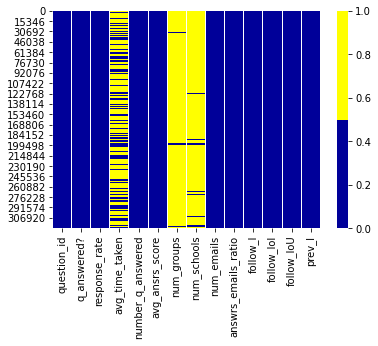

In [21]:
cols = model_dataset.columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(model_dataset[cols].isnull(), cmap=sns.color_palette(colours))

In [22]:
model_dataset["num_schools"]  =model_dataset["num_schools"].fillna(0)
model_dataset["num_groups"] = model_dataset["num_groups"].fillna(0)

In [23]:
model_dataset["avg_time_taken"]= model_dataset["avg_time_taken"][model_dataset["avg_time_taken"].notnull()].apply(lambda x: x.total_seconds()/3600)

In [24]:
model_dataset["avg_time_taken"].describe()

count    112383.000000
mean        212.373288
std         971.146922
min           0.000000
25%           2.229907
50%          11.692668
75%          47.353889
max       12390.666667
Name: avg_time_taken, dtype: float64

In [25]:
med = model_dataset["avg_time_taken"].median()
model_dataset["avg_time_taken"] = model_dataset["avg_time_taken"].fillna(med)

In [26]:
positive = model_dataset[ model_dataset["q_answered?"] != 0]
negative = model_dataset[ model_dataset["q_answered?"] == 0]

In [27]:
negative_sample = negative.sample(5000)

In [28]:
resampled_data = pd.concat([positive,negative_sample ])

In [29]:
target = resampled_data["q_answered?"]
resampled_data = resampled_data.drop(columns = ["q_answered?"])

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [31]:
x_train, x_test, y_train, y_test = train_test_split(resampled_data, target, test_size=0.2, random_state=42)

In [32]:
LR = LogisticRegression(max_iter = 10000)
LR.fit(x_train, y_train)

ValueError: could not convert string to float: '702dc3c3b3e44b0894c3335209cd3180'

In [ ]:
LR.score(x_train, y_train)

In [ ]:
LR.score(x_test, y_test)

In [ ]:
#LR.classes_
LR.predict_proba(x_test)

In [ ]:
explainer = shap.LinearExplainer(LR, x_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, x_test)

In [ ]:
shap.dependence_plot("response_rate", shap_values, x_test)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], x_test.iloc[0,:])

In [ ]:
#model_dataset.loc[0]["following_tags"]

In [ ]:
#model_dataset.loc[1]["q_tags"]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu')) # 12 neurons and expecting 8 columns x
model.add(Dense(8, activation='relu'))#8 neurons with activation function rectified
model.add(Dense(8, activation='relu'))#8 neurons with activation function rectified
model.add(Dense(1, activation='sigmoid')) #1 neuron with sigmoid activation
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(x_train, y_train, epochs = 100)

In [ ]:
#accuracy
model.evaluate(x_test, y_test, verbose = True)[1]

In [ ]:
len(tags.tags_tag_name.unique())